# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 3 - Bayesian Analysis



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 3 is due March 5th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime as dt
from scipy.special import expit


<hr style="height:2pt">

### Contraceptive Usage by Bangladeshi Women

In the second part of this assignment, you are provided with data sets `dataset_2_train.csv` and `dataset_2_test.csv`containing details of contraceptive usage by 1934 Bangladeshi women. There are four attributes for each woman, along with a label indicating if she uses contraceptives. The attributes include
* district: identifying code for the district the woman lives in
* urban: type of region of residence
* living.children: number of living children
* age-mean: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


### Part A: Bayesian Logistic Regression

The first model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

$\beta_1 \sim N(0,10000)$, $\beta_2\sim N(0,10000)$, $\beta_3 \sim N(0,10000)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$,

where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

##### **A1**

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order. Also, re-name district 60 to be district 0 so that the districts are numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

In [3]:
dtrain=pd.read_csv('data/dataset_2_train.csv')
dtest=pd.read_csv("data/dataset_2_test.csv")
dtrain.head()

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1
3,5,0,3,-4.5599,1
4,34,1,4,8.4400,0


In [4]:
dtrain.loc[dtrain['district']==61,'district']=54
dtrain.loc[dtrain['district']==60,'district']=0
dtest.loc[dtest['district']==61,'district']=54
dtest.loc[dtest['district']==60,'district']=0

In [5]:
dtrain.district.min(), dtrain.district.max()

(0, 59)

##### **A2**

First, we'll verify that pymc3 can recover the hidden parameter values. To do so, we'll hard-code known values and simulate data from the model, then using that data we'll check if pymc3 can get back the parameters we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

Use the following hard-coded values:  
$\mu_0 = 2$

$\sigma^2_0 = 1$

$\beta_{0j} \sim N(\mu_0,\sigma_0^2)$ for all sixty districts

$\beta_1 = 4$

$\beta_2 = -3$

$\beta_3 = -2$

**Verify that these parameters give an overall average of 46 to 48 percent of subjects using contraceptives**

In [6]:
b0=np.random.normal(2,1,60)
P=4*dtrain.urban-3*dtrain["living.children"]-2*dtrain.age_mean+b0[dtrain.district]
# P=1/(1+np.exp(-P));
P=expit(P)
Y=P.map(lambda x:np.random.binomial(1,x,1)[0])
print("overall average:",sum(Y)/len(Y))

overall average: 0.4725956566701138


##### **A3**

Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

Note: It is wise to take advantage of a model's built-in `summary` method to inspect it after fitting

In [7]:
from pymc3 import Model,Normal,Gamma,HalfNormal
basic_model = Model()
with basic_model:
    mu0 = Normal('mu0',mu=0,tau=1/10000)
    tau0 = Gamma('tau0',alpha=0.1,beta=0.1)
    sig0 =  pm.Deterministic('sig0',pm.math.sqrt(1/tau0))
    beta0 = Normal('beta0',mu=mu0,tau=tau0,shape=60)
    beta1 = Normal('beta1',mu=0,tau=1/10000)
    beta2 = Normal('beta2',mu=0,tau=1/10000)
    beta3 = Normal('beta3',mu=0,tau=1/10000)
#     p=pm.math.sigmoid(beta1*dtrain.urban+beta2*dtrain["living.children"]+beta3*dtrain.age_mean+beta0[dtrain.district])
    Y_hat = beta1*dtrain.urban+beta2*dtrain["living.children"]+beta3*dtrain.age_mean+beta0[dtrain.district]
    Y_obs = pm.Bernoulli('obs',logit_p=Y_hat,observed=Y)
    trace1 = pm.sample(2000,tune=5000,target_accept=0.95)

/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta3, beta2, beta1, beta0, tau0, mu0]
Sampling 2 chains, 0 divergences:   0%|  

##### **A4**

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \sigma_0, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?

/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu0,1.772,0.916,0.228,3.743,0.109,0.078,71.0,69.0,70.0,90.0,1.03
beta0[0],1.730,1.238,-0.448,4.160,0.110,0.083,127.0,113.0,117.0,264.0,1.02
beta0[1],1.982,1.150,-0.001,4.308,0.118,0.084,95.0,95.0,92.0,279.0,1.02
beta0[2],1.808,1.175,-0.290,4.147,0.111,0.079,111.0,111.0,107.0,313.0,1.02
beta0[3],1.891,1.220,-0.329,4.197,0.118,0.084,107.0,107.0,102.0,284.0,1.02
...,...,...,...,...,...,...,...,...,...,...,...
beta1,4.963,1.004,3.316,7.041,0.049,0.035,414.0,404.0,435.0,733.0,1.00
beta2,-3.465,0.598,-4.544,-2.350,0.053,0.038,127.0,127.0,125.0,635.0,1.01
beta3,-2.400,0.387,-3.145,-1.731,0.022,0.015,318.0,318.0,309.0,814.0,1.00
tau0,4.943,5.396,0.070,15.102,0.442,0.313,149.0,149.0,102.0,159.0,1.02


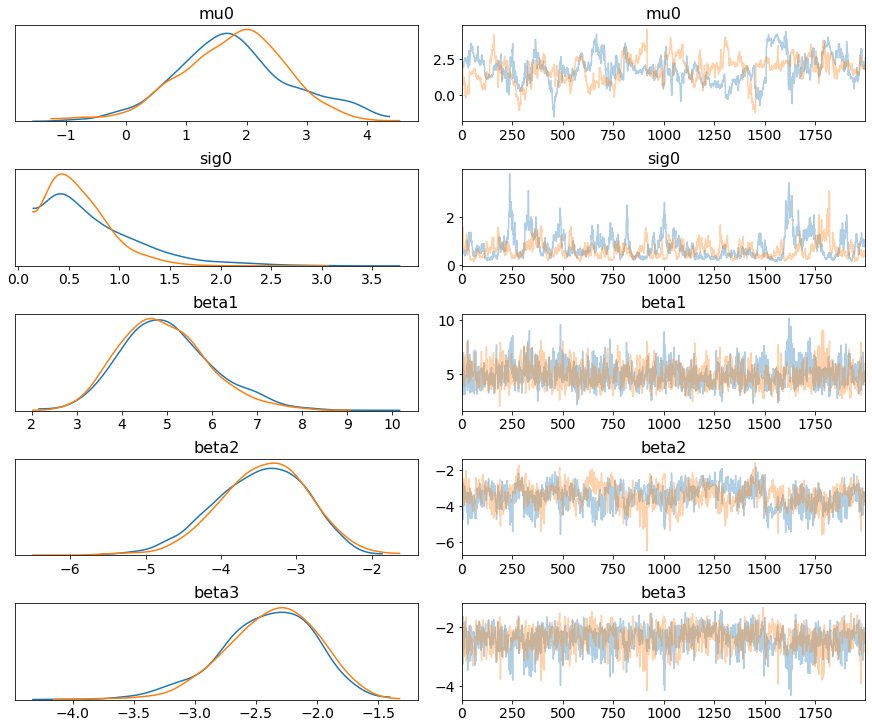

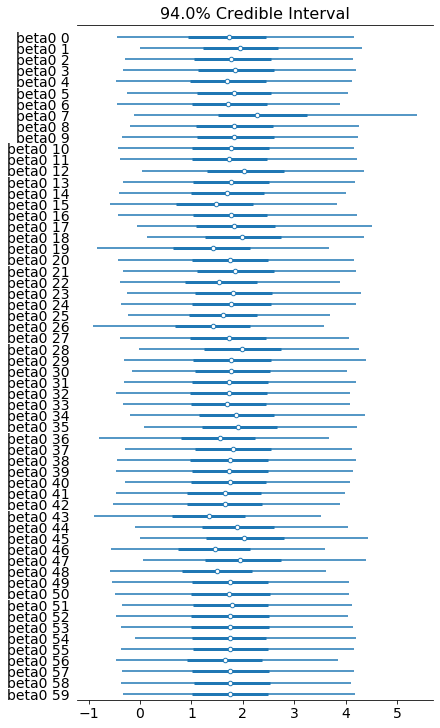

In [8]:
pm.traceplot(trace1, ['mu0','sig0','beta1','beta2','beta3']);
pm.plot_forest(trace1, var_names='beta0', combined=True)
pm.summary(trace1)

comment

The rhat statistic is larger than 1.05 for some parameters. This indicates the sampled data might have fundamental structure forbiding convergence. But overall, it looks like the samplers tend to converge to certain values. 

##### **A5**

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions? 

/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8588b07d0>,
      dtype=object)

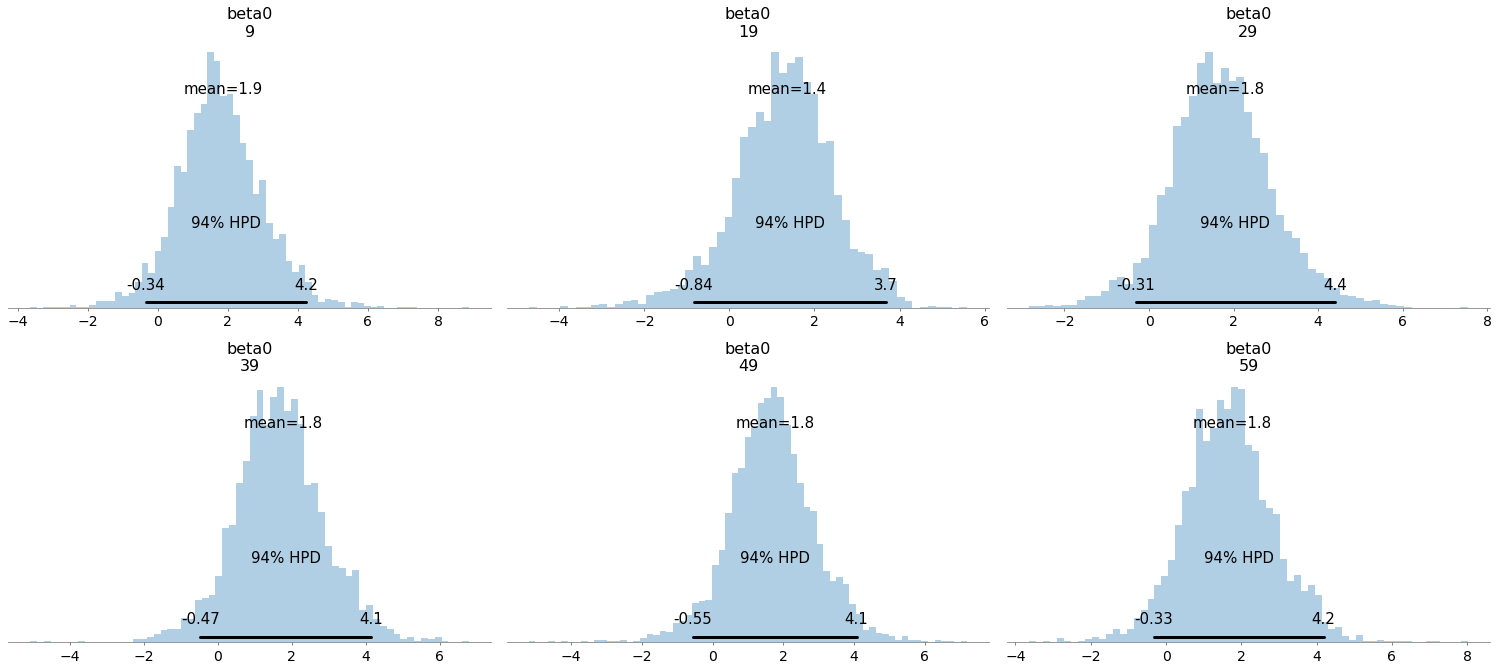

In [9]:
pm.plots.plot_posterior(trace1,var_names=['beta0'],kind='hist',coords={'beta0_dim_0':np.arange(9,69,10)})

comment

Yes, the hard-coded mu0 is 2, and we can see 2 is the mean of most distributions and definitely within 94% HPD in all posterior distributions,. So we can conclude that Pymc does return our hard-coded parameters.

##### **A6**

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [10]:
real_model = Model()
with real_model:
    mu0 = Normal('mu0',mu=0,tau=1/10000)
    tau0 = Gamma('tau0',alpha=0.1,beta=0.1)
    sig00 =  pm.Deterministic('sig00',pm.math.sqrt(1/tau0))
    beta0 = Normal('beta0',mu=mu0,tau=tau0,shape=60)
    beta1 = Normal('beta1',mu=0,tau=1/10000)
    beta2 = Normal('beta2',mu=0,tau=1/10000)
    beta3 = Normal('beta3',mu=0,tau=1/10000)
#     p=pm.math.sigmoid(beta1*dtrain.urban+beta2*dtrain["living.children"]+beta3*dtrain.age_mean+beta0[dtrain.district])
    Y_hat = beta1*dtrain.urban+beta2*dtrain["living.children"]+beta3*dtrain.age_mean+beta0[dtrain.district]
    Y_obs = pm.Bernoulli('obs',logit_p=Y_hat,observed=dtrain.contraceptive_use)
    trace2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta3, beta2, beta1, beta0, tau0, mu0]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:23<00:00, 216.45draws/s]
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
The number of effective samples is smaller than 10% for some parameters.


##### **A7**

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu0,-1.613,0.254,-2.093,-1.141,0.013,0.009,377.0,377.0,380.0,706.0,1.01
sig00,0.543,0.110,0.344,0.749,0.004,0.003,803.0,803.0,747.0,639.0,1.00
beta0[0],-2.081,0.509,-3.028,-1.095,0.014,0.010,1272.0,1272.0,1250.0,2061.0,1.00
beta0[1],-2.137,0.373,-2.818,-1.426,0.014,0.010,672.0,672.0,671.0,1231.0,1.01
beta0[2],-1.786,0.495,-2.686,-0.829,0.014,0.010,1174.0,1174.0,1169.0,1944.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
beta0[58],-1.443,0.435,-2.226,-0.576,0.014,0.010,973.0,973.0,974.0,1694.0,1.00
beta0[59],-1.854,0.539,-2.821,-0.802,0.014,0.010,1486.0,1468.0,1495.0,2146.0,1.00
beta1,0.741,0.164,0.428,1.043,0.003,0.002,2534.0,2534.0,2536.0,2740.0,1.00
beta2,0.325,0.082,0.172,0.480,0.004,0.003,388.0,388.0,388.0,769.0,1.01


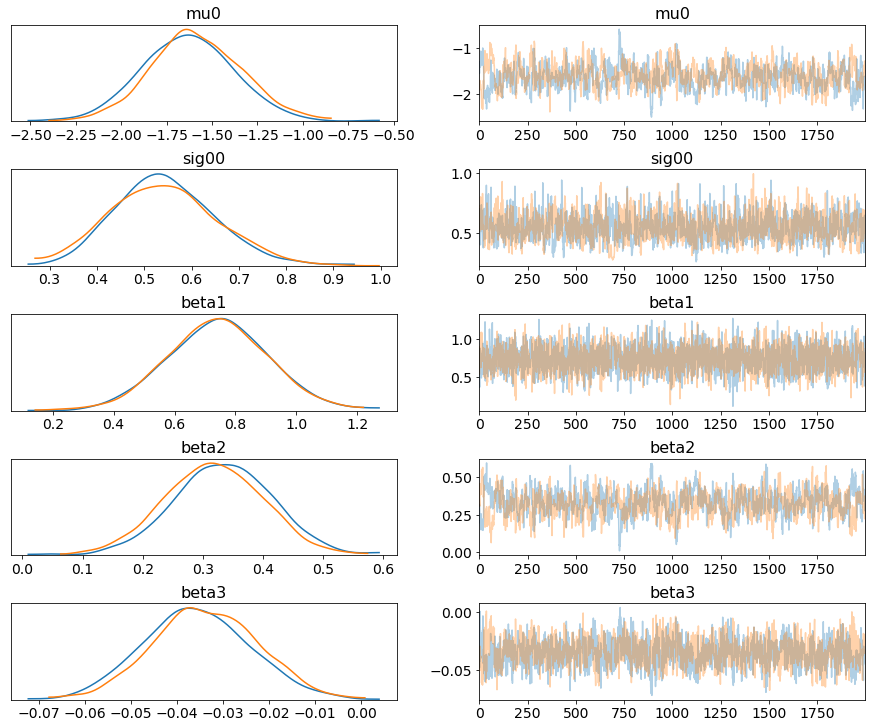

In [11]:
pm.traceplot(trace2,['mu0','sig00','beta1','beta2','beta3']);
summary = pm.summary(trace2,['mu0','sig00','beta0','beta1','beta2','beta3'])
summary

In [12]:
summary.r_hat.mean(), summary.r_hat.min(), summary.r_hat.max()

(1.0007692307692309, 1.0, 1.01)

In [13]:
summary[summary["r_hat"]!=1]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu0,-1.613,0.254,-2.093,-1.141,0.013,0.009,377.0,377.0,380.0,706.0,1.01
beta0[1],-2.137,0.373,-2.818,-1.426,0.014,0.010,672.0,672.0,671.0,1231.0,1.01
beta0[28],-2.155,0.429,-2.890,-1.274,0.014,0.010,972.0,972.0,972.0,1720.0,1.01
beta2,0.325,0.082,0.172,0.480,0.004,0.003,388.0,388.0,388.0,769.0,1.01
beta3,-0.035,0.011,-0.056,-0.014,0.000,0.000,677.0,677.0,677.0,1333.0,1.01


comment

With most of the $\hat{R}$ score equaling to 1, we can tell the chains converge mostly except for a few parameters. 

From the traceplot, we can tell the most possible values for parameters are as below:

$mu_0$: -1.613.

$sig00$: 0.543

beta1: 0.741

beta2: 0.325

beta3: -0.035

##### **A8**

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/share/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)
/usr/share/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' wi

District with highest base rate: beta0[56]
District with lowest base rate: beta0[11]


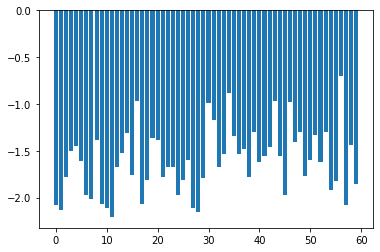

In [14]:
summary = pm.summary(trace2,['beta0'])
b=summary["mean"]
print("District with highest base rate:",np.argmax(b))
print("District with lowest base rate:",np.argmin(b))
plt.bar([i for i in range (60)],b)
plt.show()

##### **A9**

What are the posterior means of $\mu_0$ and $\sigma^2_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts or a model with an intercept of 0 for all districts?

In [17]:
summary=pm.summary(trace2,['mu0','sig00'])
print(summary["mean"].loc["mu0"])
print(summary["mean"].loc["sig00"])

/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


-1.613
0.543


comment

Yes, given that the mean of the intercept is -1.613, we can tell that the base rate of women using contraceptive is actually not 0. Women have a tendency to use it. The variance of the intercepts is 0.543 which shows the base rate of women using contraceptive has a very big fluctuation across districts. Women in different districts are influenced by multiple reasons to have varied tendencies of using contraceptive.

### Part B: Varying-Coefficients Model

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma_0^2} \sim \text{Gamma}(0.1,0.1)$.

$\beta_{1j} \sim N(0,\sigma_1^2)$, with $\frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1)$

$\beta_{2j}\sim N(0,\sigma_2^2)$, with $\frac{1}{\sigma^2_2}\sim \text{Gamma}(0.1,0.1)$

$\beta_{3j} \sim N(0,\sigma_3^2)$, with $\frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}$,

##### **B1**

Fit the model to the real data. Plot posterior means for each of the coefficients to the predictors. What do you conclude from these graphs?

In [18]:
vary_model = Model()

with vary_model:
    mu0 = Normal('mu0',mu=0,tau=1/10000)
    tau0 = Gamma('tau0',alpha=0.1,beta=0.1)
    tau1 = Gamma('tau1',alpha=0.1,beta=0.1)
    tau2 = Gamma('tau2',alpha=0.1,beta=0.1)
    tau3 = Gamma('tau3',alpha=0.1,beta=0.1)
    sig0b =  pm.Deterministic('sig0b',1/tau0)
    sig1b =  pm.Deterministic('sig1b',1/tau1)
    sig2b =  pm.Deterministic('sig2b',1/tau2)
    sig3b =  pm.Deterministic('sig3b',1/tau3)
    beta0 = Normal('beta0',mu=mu0,tau=tau0,shape=60)
    beta1 = Normal('beta1',mu=0,tau=tau1,shape=60)
    beta2 = Normal('beta2',mu=0,tau=tau2,shape=60)
    beta3 = Normal('beta3',mu=0,tau=tau3,shape=60)
#     p = pm.math.sigmoid(beta1[dtrain.district]*dtrain.urban+beta2[dtrain.district]*dtrain["living.children"]+beta3[dtrain.district]*dtrain.age_mean+beta0[dtrain.district])
    Y_hat = beta1[dtrain.district]*dtrain.urban+beta2[dtrain.district]*dtrain["living.children"]+beta3[dtrain.district]*dtrain.age_mean+beta0[dtrain.district]
    Y_obs = pm.Bernoulli('obs',logit_p=Y_hat,observed=dtrain.contraceptive_use)
    trace3 = pm.sample(2000, tune=5000, target_accept=0.95)

/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta3, beta2, beta1, beta0, tau3, tau2, tau1, tau0, mu0]
Sampling 2 chains, 0 di

/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr

(<Figure size 432x295.2 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd84be1ab10>],
       dtype=object))

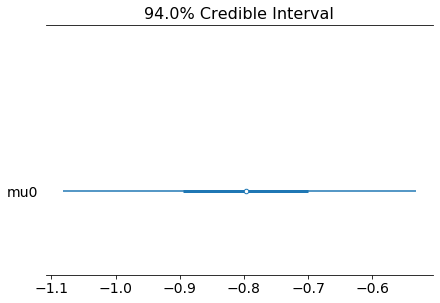

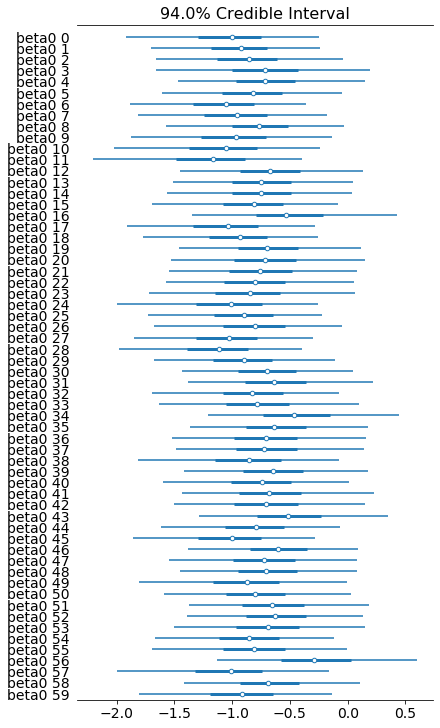

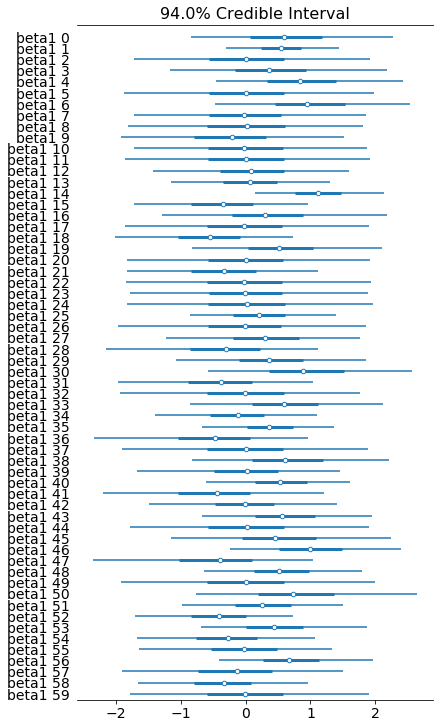

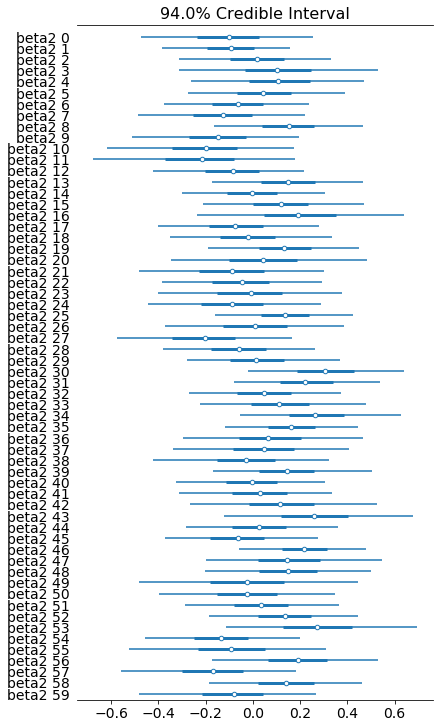

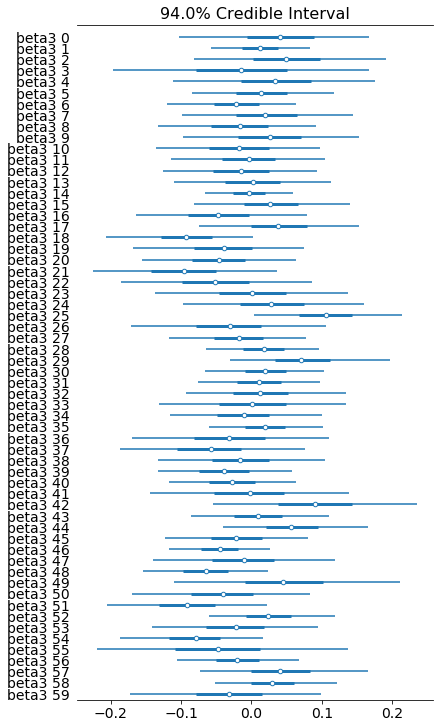

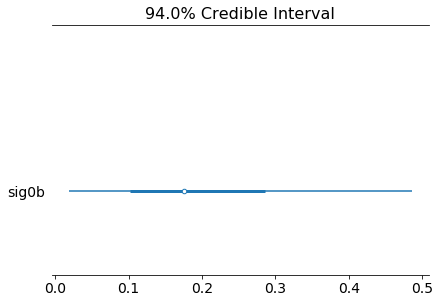

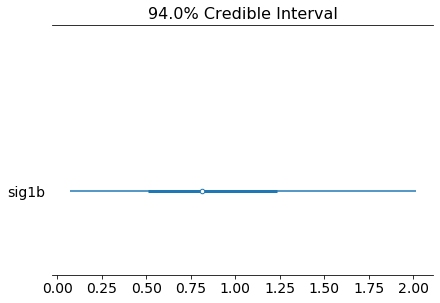

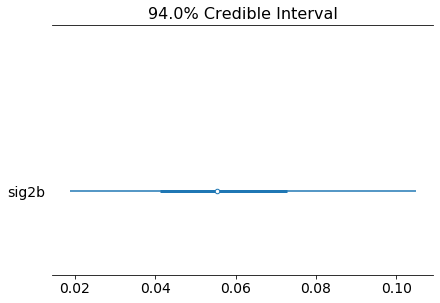

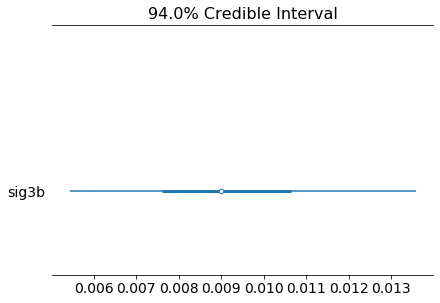

In [19]:
pm.plot_forest(trace3, var_names='mu0', combined=True)
pm.plot_forest(trace3, var_names='beta0', combined=True)
pm.plot_forest(trace3, var_names='beta1', combined=True)
pm.plot_forest(trace3, var_names='beta2', combined=True)
pm.plot_forest(trace3, var_names='beta3', combined=True)
pm.plot_forest(trace3, var_names='sig0b', combined=True)
pm.plot_forest(trace3, var_names='sig1b', combined=True)
pm.plot_forest(trace3, var_names='sig2b', combined=True)
pm.plot_forest(trace3, var_names='sig3b', combined=True)

/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0[0],-1.042,0.444,-1.917,-0.246,0.012,0.009,1400.0,1210.0,1495.0,1659.0,1.00
beta0[1],-0.940,0.383,-1.704,-0.239,0.008,0.006,2466.0,1990.0,2497.0,2444.0,1.00
beta0[2],-0.870,0.426,-1.660,-0.038,0.008,0.007,2923.0,1924.0,3054.0,2110.0,1.00
beta0[3],-0.701,0.481,-1.662,0.191,0.009,0.007,2634.0,2634.0,2758.0,1779.0,1.00
beta0[4],-0.701,0.421,-1.470,0.147,0.009,0.006,2238.0,2238.0,2359.0,2118.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
beta3[59],-0.033,0.071,-0.172,0.099,0.001,0.001,9392.0,1829.0,9319.0,2681.0,1.00
sig0b,0.216,0.157,0.019,0.486,0.009,0.006,330.0,330.0,272.0,651.0,1.01
sig1b,0.939,0.603,0.068,2.015,0.039,0.028,240.0,240.0,172.0,178.0,1.00
sig2b,0.059,0.025,0.019,0.105,0.001,0.001,670.0,670.0,656.0,1485.0,1.00


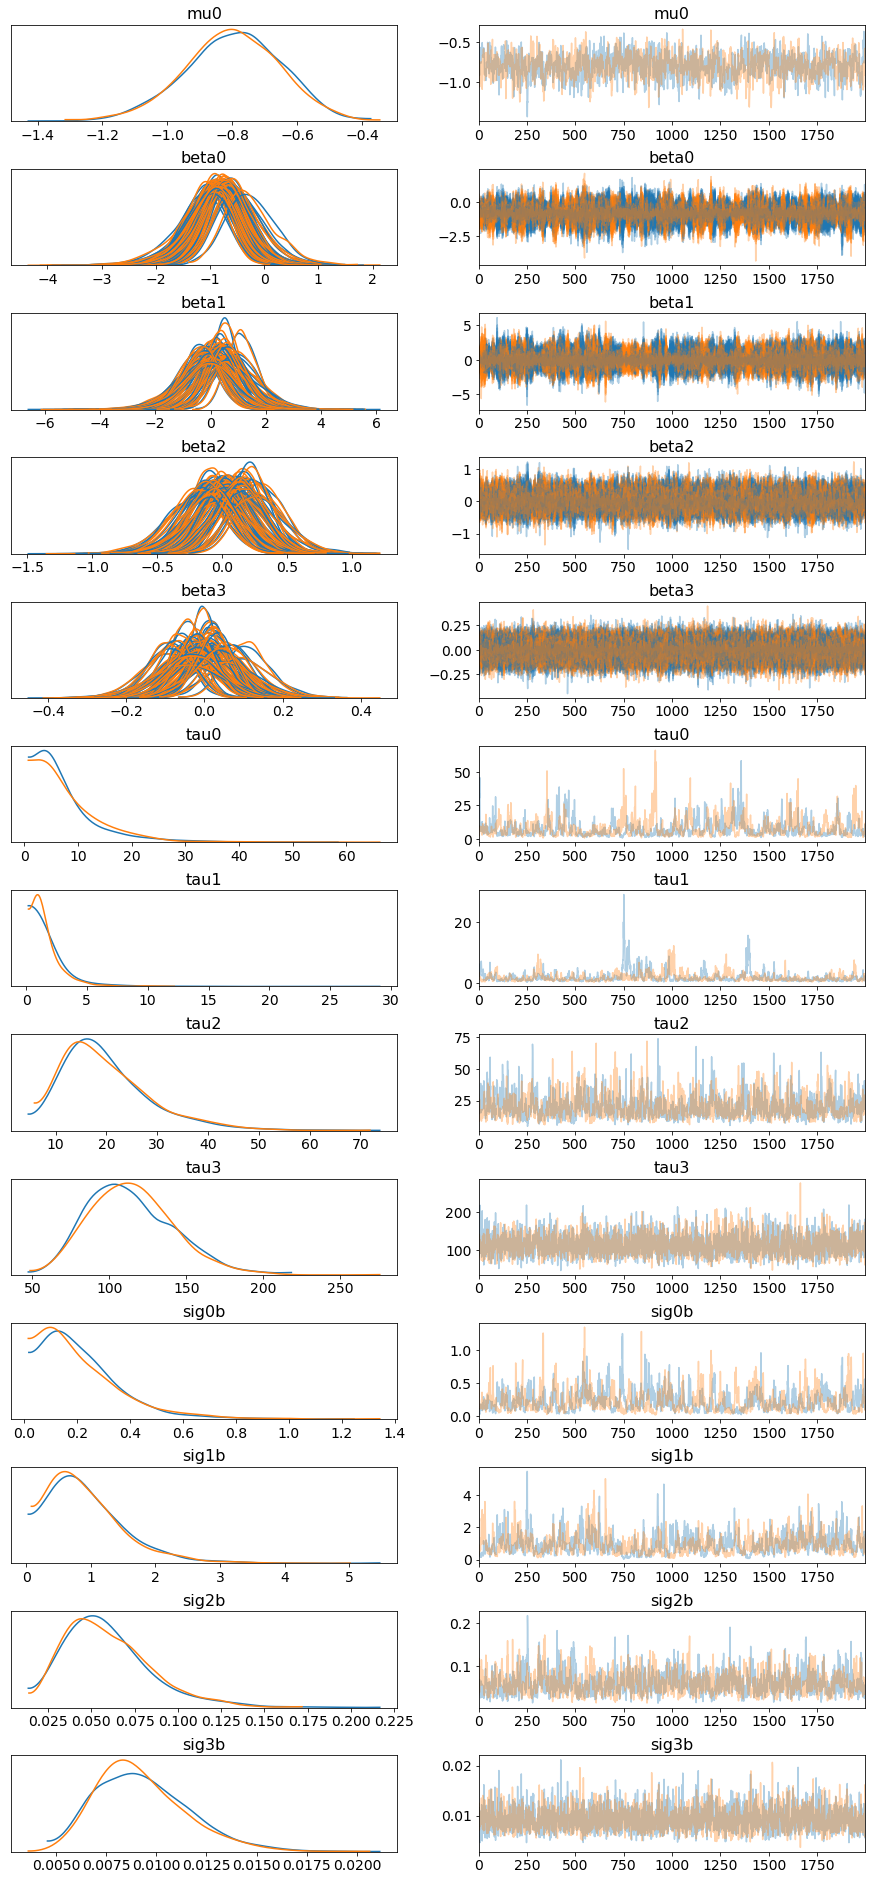

In [20]:
pm.traceplot(trace3)
summary2 = pm.summary(trace3,["beta0","beta1","beta2","beta3","sig0b","sig1b","sig2b","sig3b"])
summary2

comment

From the traceplot, we can see that beta1, beta2, beta3 have pretty different distributions across districts. The variance of each parameter is large which indicates different districts have different regression parameters. The parameters of urban, age, living_children have different impact on the final tendency of women using contracep in different districts.

It also explains why certain parameters have $\hat{R}$ larger than 1.01. Due to the fundamental different across districts, we should use the varing-coefficients model as our prediction model.

##### **B2**

Use all of the information you've gleaned thus far to build a final Bayesian logistic regression classifier on the train set. Then, use your model to make predictions on the test set. Report your model's classification percentage.

In [21]:
final_model = Model()
with final_model:
    mu0 = Normal('mu0',mu=0,tau=1/10000)
    tau0 = Gamma('tau0',alpha=0.1,beta=0.1)
    tau1 = Gamma('tau1',alpha=0.1,beta=0.1)
    tau2 = Gamma('tau2',alpha=0.1,beta=0.1)
    tau3 = Gamma('tau3',alpha=0.1,beta=0.1)
    beta0 = Normal('beta0',mu=mu0,tau=tau0,shape=60)
    beta1 = Normal('beta1',mu=0,tau=tau1,shape=60)
    beta2 = Normal('beta2',mu=0,tau=tau2,shape=60)
    beta3 = Normal('beta3',mu=0,tau=tau3,shape=60)
    s1 = beta1[dtrain.district]
    s2 = beta2[dtrain.district]
    s3 = beta3[dtrain.district]
    s11 = beta1[dtest.district]
    s22 = beta2[dtest.district]
    s33 = beta3[dtest.district]
    pi = pm.Deterministic('$P_i$',pm.math.sigmoid(s1*dtrain.urban+s2*dtrain["living.children"]+s3*dtrain.age_mean+beta0[dtrain.district]))
    pi_test = pm.Deterministic('$P_i_test$',pm.math.sigmoid(s11*dtest.urban+s22*dtest["living.children"]+s33*dtest.age_mean+beta0[dtest.district]))
    Y_obs = pm.Bernoulli('obs',p=pi, observed=dtrain.contraceptive_use)
    trace4 = pm.sample(2000)

/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for mu

In [22]:
print(sum((trace4["$P_i_test$"].mean(axis=0)>0.5)==(dtest.contraceptive_use))/len(dtest))

0.6215098241985523


In [24]:
for i in range(60):
    district = dtest.loc[dtest['district']==i]
    beta0=summary2['mean']['beta0[{}]'.format(i)]
    beta1=summary2['mean']['beta1[{}]'.format(i)]
    beta2=summary2['mean']['beta2[{}]'.format(i)]
    beta3=summary2['mean']['beta3[{}]'.format(i)]
    
    y_hat = beta0+beta1*district['urban']+beta2*district['living.children']+beta3*district['age_mean']
    prob = expit(y_hat)
    dtest.loc[dtest['district']==i, 'est'] = prob

In [30]:
len(dtest.loc[dtest['est']>0.5])/len(dtest)

0.2647362978283351

In [31]:
dtest

,district,urban,living.children,age_mean,contraceptive_use,est
0,1,1,4,18.4400,0,0.365465
1,1,1,1,-5.5599,0,0.366162
2,1,1,4,8.4400,0,0.338112
3,1,1,2,-5.5599,0,0.343955
4,1,1,4,1.4400,0,0.319576
...,...,...,...,...,...,...
962,54,0,4,19.4400,0,0.048125
963,54,0,3,-9.5599,1,0.378094
964,54,0,3,-2.5599,0,0.256422
965,54,0,4,14.4400,0,0.070460
